<a href="https://colab.research.google.com/github/steffenschneider/MRI-tumor-detection/blob/main/mri_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries


In [50]:
# !pip install tensorflow

import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow
from tensorflow import keras
from keras import layers, metrics, callbacks, applications, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(os.getcwd())

C:\Users\Steffen


# get data

In [51]:
data_dir = "C:/Users/Steffen/kaggle/mri-data"

# for use in Google Colab
'''
if not os.path.exists('/content'):
    os.makedirs('/content')

import shutil
#shutil.rmtree('')

from google.colab import files
uploaded = files.upload()       # choose zip folder manually

data_dir = "./mri-tumor"  # contains "yes" and "no" folders

import zipfile
with zipfile.ZipFile('mri-data.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

shutil.rmtree(data_dir + '/brain_tumor_dataset')    # delete additional redundant files
'''

'\nif not os.path.exists(\'/content\'):\n    os.makedirs(\'/content\')\n\nimport shutil\n#shutil.rmtree(\'\')\n\nfrom google.colab import files\nuploaded = files.upload()       # choose zip folder manually\n\ndata_dir = "./mri-tumor"  # contains "yes" and "no" folders\n\nimport zipfile\nwith zipfile.ZipFile(\'mri-data.zip\', \'r\') as zip_ref:\n    zip_ref.extractall(data_dir)\n\nshutil.rmtree(data_dir + \'/brain_tumor_dataset\')    # delete additional redundant files\n'

# split data into training and test

In [52]:
img_size = (224, 224)  # ResNet50 requires 224x224
batch_size = 25

# First split: 80% train, 20% validation and test
# color_mode="rgb" is needed for ResNet50, which expects 3 channels
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,        # image is resized here
    batch_size=batch_size,
    color_mode="rgb"
)

# color_mode="rgb" is needed for ResNet50, which expects 3 channels
temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,        # image is resized here
    batch_size=batch_size,
    color_mode="rgb"
)

# Second split: Split temp into 50% validation, 50% test (10% each of original)
n_batches = 1
val_ds = temp_ds.take(n_batches)     # 25 pictures for validation
test_ds = temp_ds.skip(n_batches)    # 25 pictures for testing

data_count = 0
for batch in test_ds:
    images, labels = batch
    data_count += len(images)
print(f"Sum of data / pictures: {data_count}")



Found 253 files belonging to 2 classes.
Using 203 files for training.


Found 253 files belonging to 2 classes.
Using 50 files for validation.
Sum of data / pictures: 25


# augmentation

In [53]:
# AUGMENTATION
# no new images are created, only the original images are augmented
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomBrightness(0.2)
])


# normalization

In [54]:
# NORMALIZATION
# Normalize the images to [0,1] range
# ResNet50 expects images in the range [-1,1]
def preprocess(image, label):
    image = data_augmentation(image)
    #image = tf.keras.applications.resnet50.preprocess_input(image)  # Normalize images, DOES NOT WORK!!!
    image = image / 255.0  # Scale pixel values to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

'''
data_count = 0
for batch in test_ds:
    images, labels = batch
    print(images[0][0][0])      # tf.Tensor([0.3997549 0.3997549 0.3997549], shape=(3,), dtype=float32)
'''


'\ndata_count = 0\nfor batch in test_ds:\n    images, labels = batch\n    print(images[0][0][0])      # tf.Tensor([0.3997549 0.3997549 0.3997549], shape=(3,), dtype=float32)\n'

# build and compile model

In [55]:

# MODEL
# ResNet50 as feature extractor
# use ResNet50V2 with ImageNet weights - pre-trained model!
# V2 with better accuracy!
# only two output classes: "yes" and "no"
base_model = keras.applications.ResNet50V2(
    include_top=False,              # use my own input layer and output layer
    weights="imagenet",
    input_shape=(224, 224, 3),      # ResNet50V2 needs 3 channels
    classes=2,
    name="resnet50v2",
)

# use trainable = False if < 10.000 images (avoids overfitting)
base_model.trainable = False  # Freeze the base model

# BUILDING THE MODEL
# Why sigmoid? Because we have only two classes (binary classification)
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(1, activation="sigmoid")
])

# COMPILE MODEL
# Adam optimizer is often the best choice for transfer learning
# use binary_crossentropy for binary classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),   # 0.001 is standard; 
                                                            # because ReduceLROnPlateau is used, learning rate will change automatically
    loss="binary_crossentropy",
    metrics=[
        "accuracy",           
        metrics.Precision(),       
        metrics.Recall()          
    ]
)


# class weights

In [56]:

# CLASS WEIGHTS
# Calculate class weights to balance the dataset
# n_yes = 155
# n_no = 98
dir_no = os.path.join(data_dir, 'no')
n_no = len(os.listdir(dir_no))
print(f"amount of no-files: {n_no}")

dir_yes = os.path.join(data_dir, 'yes')
n_yes = len(os.listdir(dir_yes))
print(f"amount of yes-files: {n_yes}")

ratio = n_yes / n_no
class_weights = {0: ratio, 1: 1.0}  # ratio is 1.62


amount of no-files: 98
amount of yes-files: 155


# model training

In [57]:
# TRAINING
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

learning_rate_schedule = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.5,             # reduce learning rate by factor 0.5
    patience=3,             
    min_lr=1e-7             # no lower than 1e-7
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stopping, learning_rate_schedule],
)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4577 - loss: 1.8759 - precision_7: 0.6069 - recall_7: 0.4635 - val_accuracy: 0.5200 - val_loss: 0.9596 - val_precision_7: 0.5200 - val_recall_7: 1.0000 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5791 - loss: 1.4772 - precision_7: 0.6978 - recall_7: 0.5622 - val_accuracy: 0.6800 - val_loss: 0.7870 - val_precision_7: 0.6667 - val_recall_7: 1.0000 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7698 - loss: 0.9397 - precision_7: 0.9054 - recall_7: 0.7059 - val_accuracy: 0.8000 - val_loss: 0.6170 - val_precision_7: 0.7619 - val_recall_7: 1.0000 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7817 - loss: 0.7967 - precision_7: 0.8973 - recall_7: 0.7408 - val_accuracy: 0.8000 - val_loss: 0.6511 - val_precision_7: 0.7727 - val_recall_7: 1.0000 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/

# evaluation + confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8000 - loss: 0.5549 - precision_7: 0.7619 - recall_7: 1.0000
Test Accuracy: 0.8000


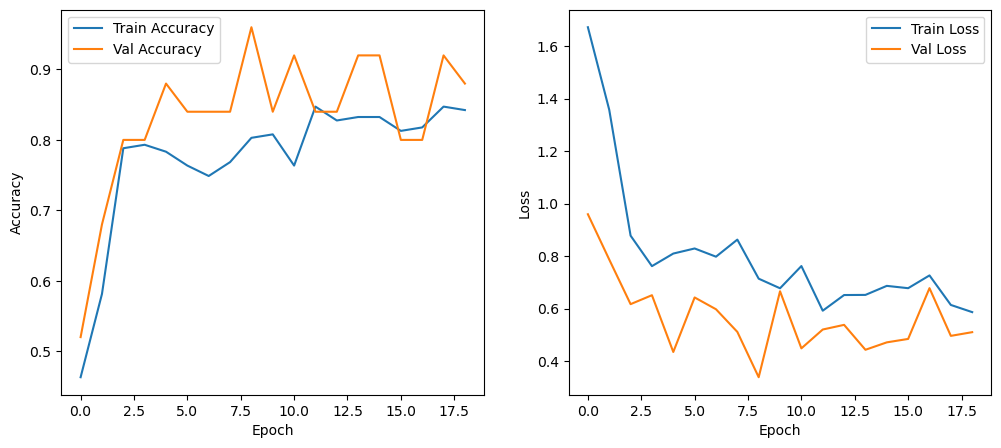

(25, 224, 224, 3)
(25,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


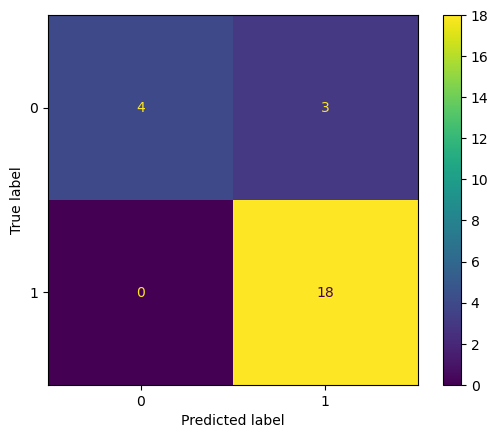

(25, 224, 224, 3)
(25,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


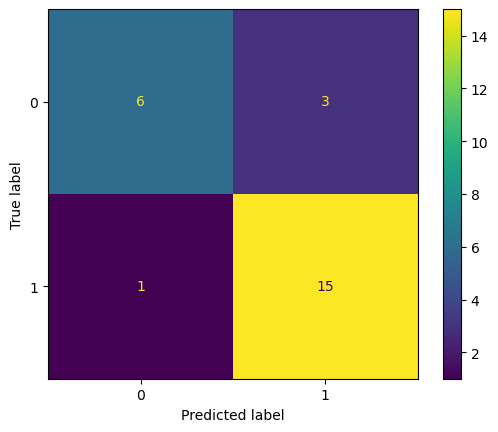

In [59]:

# EVALUATION
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# PREDICTION
y_val = []
y_val_pred = []
for images, labels in val_ds:
    print(images.shape)
    print(labels.shape)
    y_val.extend(labels)
    y_val_pred.extend(model.predict(images))

# Confusion Matrix validation
cm = confusion_matrix(y_val, np.round(y_val_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

y_test = []
y_test_pred = []
for images, labels in test_ds:
    print(images.shape)
    print(labels.shape)
    y_test.extend(labels)
    y_test_pred.extend(model.predict(images))

# Confusion Matrix test
cm = confusion_matrix(y_test, np.round(y_test_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
